In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import numpy as np
from scipy import signal, stats
import requests

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# default colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "b", "g", "y", "k", "c", "m", "orange"])

In [38]:
data = dict()

for mixture in tqdm([
    f"Ar_{100-fraction:0.1f}-C4H10_{fraction:0.1f}" for fraction in np.arange(0.5, 20.5, 0.5)
]):
    url = f"https://lobis.github.io/gas-files/files/mixtures/Ar-C4H10/{mixture}.gas.json"
    r = requests.get(url)
    data[mixture] = r.json()


100%|██████████| 40/40 [00:06<00:00,  6.31it/s]


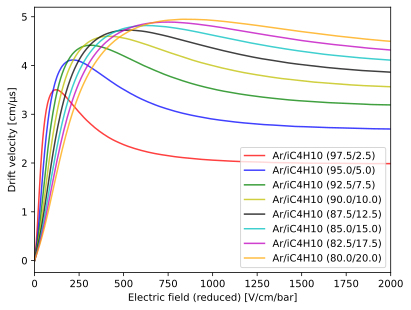

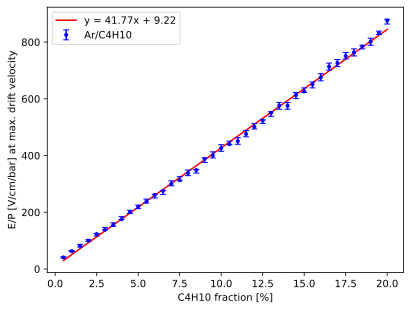

In [42]:
def mixture_string_to_label(gas):
    components = gas["components"]
    fractions = [f"{x * 100:0.1f}" for x in components["fractions"]]
    labels = [label for label in components["labels"]]
    return f"""{"/".join(labels)} ({"/".join(fractions)})"""


quencher_fraction = np.array([data[mixture]["components"]
                              ["fractions"][1] * 100 for mixture in data])
max_drift_velocity_efield = np.zeros(len(data))
max_drift_velocity_efield_err = np.zeros((2, len(data)))
for i, (mixture, gas) in enumerate(data.items()):
    components = gas["components"]
    x = np.array(gas["electric_field"]) / gas["pressure"]
    y = np.array(gas["electron_drift_velocity"])

    # find absolute maximum in a region of drift fields. The value may need to be adjusted for each mixture
    peak = np.argmax(y[np.where(x < 2500)])

    max_drift_velocity_efield[i] = x[peak]
    max_drift_velocity_efield_err[0,
                                  i] = max_drift_velocity_efield[i] - x[max(0, peak - 1)]
    max_drift_velocity_efield_err[1, i] = x[min(
        len(x) - 1, peak + 1)] - max_drift_velocity_efield[i]

    if components["fractions"][0] * 100 % 2.5 != 0:
        # do not plot all
        continue
    plt.plot(x, y, label=mixture_string_to_label(gas), alpha=0.75)

plt.xlabel("Electric field (reduced) [V/cm/bar]")
plt.ylabel("Drift velocity [cm/μs]")
plt.xlim(0, 2000)
plt.legend()
plt.show()

# plot max drift velocity vs % of quencher

regression = stats.linregress(quencher_fraction, max_drift_velocity_efield)
label = f"y = {regression.slope:.2f}x + {regression.intercept:.2f}"
plt.plot(quencher_fraction, regression.intercept + regression.slope *
         quencher_fraction, label=label)
plt.errorbar(quencher_fraction, max_drift_velocity_efield,
             yerr=max_drift_velocity_efield_err, fmt=".", capsize=3, label="Ar/C4H10")
# plt.title("Maximum drift velocity vs. % of quencher")
plt.ylabel("E/P [V/cm/bar] at max. drift velocity")
plt.xlabel("C4H10 fraction [%]")
plt.legend()
plt.show()
